In [17]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 5
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


In [18]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [19]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

source_sequence = []
max_count = 300000
max_source_len = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source_len < len(source):
        max_source_len = len(source)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    #* for Chromosome /- for Family /No Split for Allele
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
source_sequence = np.array(source_sequence)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, max_source_len)
print(vgene_tag.shape, vgenes)


(288774,) 526
(288774,) 63


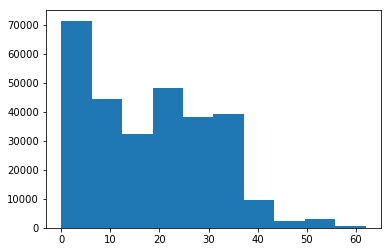

In [20]:
import matplotlib.pyplot as plt

plt.hist(vgene_tag)
plt.show()

In [21]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

x_data = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
y_data = to_categorical(vgene_tag)

train_index = int((len(x_data) / batch_size) * 0.80 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (231019, 288773, 346527)
(231019, 526) (231019, 63)
(57754, 526) (57754, 63)
(1, 526) (1, 63)


# Deep Network with CNN Layer

In [24]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import MaxPooling1D


embedding_size = 5
conv_unit = 16
pool_len = 3

input_source = Input(shape=(max_source_len,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source_len, \
                      name='embedding')(input_source)

conv_layer = Conv1D(conv_unit, 3, activation='relu', padding='same')(embedding)
conv_layer = Conv1D(conv_unit, 3, activation='relu', padding='same')(conv_layer)
pool_layer = MaxPooling1D(pool_len)(conv_layer)
conv_layer = Dropout(0.25)(pool_layer)

reshape_layer = Flatten()(conv_layer)

dense_layer_first = Dense(512, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
embedding (Embedding)        (None, 526, 5)            30        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 526, 16)           256       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 526, 16)           784       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 175, 16)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 175, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2800)              0         
__________

In [25]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=50, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 231019 samples, validate on 57754 samples
Epoch 1/50
 - 78s - loss: 2.9389 - acc: 0.2176 - val_loss: 1.5844 - val_acc: 0.4853
Epoch 2/50
 - 77s - loss: 1.3074 - acc: 0.5773 - val_loss: 0.7482 - val_acc: 0.7505
Epoch 3/50
 - 76s - loss: 0.7708 - acc: 0.7474 - val_loss: 0.4403 - val_acc: 0.8434
Epoch 4/50
 - 76s - loss: 0.5421 - acc: 0.8236 - val_loss: 0.3185 - val_acc: 0.8812
Epoch 5/50
 - 76s - loss: 0.4287 - acc: 0.8619 - val_loss: 0.2528 - val_acc: 0.9005
Epoch 6/50
 - 76s - loss: 0.3582 - acc: 0.8845 - val_loss: 0.2324 - val_acc: 0.9098
Epoch 7/50
 - 76s - loss: 0.3142 - acc: 0.9002 - val_loss: 0.2049 - val_acc: 0.9162
Epoch 8/50
 - 76s - loss: 0.2830 - acc: 0.9098 - val_loss: 0.1922 - val_acc: 0.9194
Epoch 9/50
 - 76s - loss: 0.2646 - acc: 0.9157 - val_loss: 0.1804 - val_acc: 0.9231
Epoch 10/50
 - 76s - loss: 0.2401 - acc: 0.9231 - val_loss: 0.1772 - val_acc: 0.9248
Epoch 11/50
 - 76s - loss: 0.2318 - acc: 0.9264 - val_loss: 0.1583 - val_acc: 0.9334
Epoch 12/50
 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
51 51


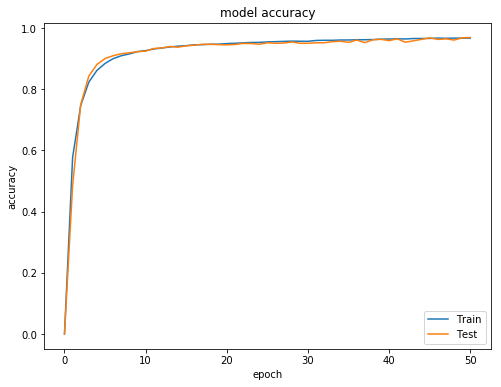

In [26]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['acc']
valid = history.history['val_acc']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


In [27]:
score = model.evaluate(x_data, y_data, \
                       batch_size=1000, verbose=2)
print(score)

import time

start = time.time()
score = model.evaluate(x_data, y_data, \
                       batch_size=1000, verbose=2)
end = time.time()

print(score, end-start)

print(100000*26.0611629486084/len(x_data))

[0.04106923093236384, 0.9856219729515114]
[0.04106923093236384, 0.9856219729515114] 135.87773752212524
9.024760867878825
